# UCI regression with outliers

In [1]:
import jax
import optax
import pickle
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
    "OGD": "blueviolet",
}

## Load dataset

In [3]:
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    print(dataset_name, dataset.shape)

protein-tertiary-structure (45731, 10)
naval-propulsion-plant (11935, 18)
wine-quality-red (1600, 12)
bostonHousing (507, 14)
power-plant (9569, 5)
concrete (1031, 9)
energy (769, 9)
kin8nm (8193, 9)
yacht (309, 7)


In [4]:
dataset_name = "yacht"
dataset_name = "naval-propulsion-plant"
noise_type = "target" # or "covariate"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 100
v_error = 50
seed_init = 314
p_error = 0.10
for i in range(n_runs):
    if noise_type == "target":
        data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].astype(bool)
    elif noise_type == "covariate":
        data = uci.sample_noisy_covariates(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    else:
        raise KeyError(f"Noise {noise_type} not available")
        
    X = data["X"]
    y = data["y"]
    
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [5]:
n_samples = y.shape[0]
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T
X_collection.shape

(100, 10742, 17)

## Setup

In [6]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [7]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [8]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [9]:
Q = 0.0
observation_covariance = 1.0

In [10]:
key = jax.random.PRNGKey(314)
model = MLP()
def latent_fn(x): return x
measurement_fn = model.apply
params_init = model.init(key, X[:1])

# Run experiments

In [11]:
time_methods = {}
hist_methods = {}
configs = {}

In [12]:
observation_covariance = jnp.eye(1) * 1.0

## Kalman Filter

In [13]:
def filter_kf(log_lr, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=1e8,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr):
    yhat_pp = filter_kf(log_lr, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [14]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -0.5188   | -0.4156   |
| 2         | -0.9546   | -2.057    |
| 3         | -0.6848   | -3.675    |
| 4         | -0.8802   | -1.084    |
| 5         | -1.155    | -0.41     |
| 6         | -0.3959   | -2.846    |
| 7         | -0.3959   | -2.846    |
| 8         | -0.5557   | -0.4199   |
| 9         | -0.9356   | -2.84     |
| 10        | -0.5763   | -2.85     |
| 11        | -0.9268   | -0.4255   |
| 12        | -0.6364   | -2.857    |
| 13        | -0.6552   | -2.863    |
| 14        | -0.5006   | -2.87     |
| 15        | -0.4834   | -2.874    |
CPU times: user 33.7 s, sys: 45.5 s, total: 1min 19s
Wall time: 7.25 s


In [15]:
method = "KF"
log_lr = bo.max["params"]["log_lr"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = jax.jit(filter_kf)(log_lr, y, X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


## KF-B

In [16]:
@jax.jit
def filter_kfb(log_lr, alpha, beta, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = rkf.ExtendedKalmanFilterBernoulli(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        n_inner=n_inner
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, alpha, beta, n_inner):
    yhat_pp = filter_kfb(log_lr, alpha, beta, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [17]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0),

        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |   alpha   |   beta    |  log_lr   |  n_inner  |
-------------------------------------------------------------------------
| 2         | -0.05594  | 4.59      | 4.137     | -1.36     | 3.344     |
| 3         | -0.03985  | 4.559     | 1.304     | -1.168    | 3.354     |
| 7         | -0.03929  | 2.853     | 2.399     | -0.6946   | 8.513     |
| 25        | -0.0185   | 3.087     | 0.04429   | -0.3136   | 5.678     |
| 28        | -0.01543  | 4.583     | 0.7118    | 0.0       | 10.0      |


In [18]:
method = "KF-B"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_kfb(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:19<00:00,  2.59s/it]


## KF-IW

In [19]:
@jax.jit
def filter_kfiw(log_lr, noise_scaling, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = rkf.ExtendedKalmanFilterInverseWishart(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance,
        n_inner=n_inner,
        noise_scaling=noise_scaling
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, noise_scaling, n_inner):
    yhat_pp = filter_kfiw(log_lr, noise_scaling, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [20]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "noise_scaling": (1e-6, 20),
        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   |  n_inner  | noise_... |
-------------------------------------------------------------


In [21]:
method = "KF-IW"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_kfiw(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


## WLF-IMQ

In [22]:
@jax.jit
def filter_wlfimq(log_lr, soft_threshold, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, soft_threshold):
    yhat_pp = filter_wlfimq(log_lr, soft_threshold, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [23]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "soft_threshold": (1e-6, 20)
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 1         | -0.05871  | -0.4156   | 11.77     |
| 2         | -0.08106  | -3.675    | 15.66     |
| 3         | -0.07878  | -0.41     | 16.55     |
| 4         | -0.03827  | -1.36     | 5.21      |
| 5         | -0.02445  | -0.4412   | 5.215     |
| 6         | -0.01196  | 0.0       | 2.92      |
| 7         | -0.6949   | 0.0       | 1e-06     |
| 8         | -0.04718  | -0.6728   | 8.498     |
| 9         | -0.0784   | -3.392    | 10.29     |
| 10        | -0.08144  | -4.352    | 6.99      |
| 11        | -0.08696  | -2.847    | 19.32     |
| 12        | -0.08083  | -4.204    | 3.601     |
| 13        | -0.08204  | -4.973    | 12.88     |
| 14        | -0.1002   | -0.02324  | 19.86     |
| 15        | -0.07805  | -1.799    | 13.8      |
CPU times: user 1min 3s, sys: 1min 9s, total: 2min 12s
Wall time: 8.51 s


In [24]:
method = "WLF-IMQ"
log_lr = bo.max["params"]["log_lr"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_wlfimq(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


## WLF-MD

In [162]:
@jax.jit
def filter_wlfmd(log_lr, threshold, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        threshold=threshold,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, threshold):
    yhat_pp = filter_wlfmd(log_lr, threshold, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [163]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "threshold": (1e-6, 20)
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
| 1         | -0.01525  | -0.4156   | 11.77     |
| 2         | -0.07926  | -3.675    | 15.66     |
| 3         | -0.01566  | -0.41     | 16.55     |
| 4         | -0.03223  | -1.36     | 5.21      |
| 5         | -0.01679  | -0.4412   | 5.215     |
| 6         | -0.02883  | -1.168    | 5.231     |
| 7         | -0.08164  | -4.389    | 7.72      |
| 8         | -0.02147  | -0.7996   | 5.564     |
| 9         | -0.08219  | -4.65     | 12.66     |
| 10        | -0.05334  | -2.076    | 11.62     |
| 11        | -0.0413   | -1.614    | 13.74     |
| 12        | -0.06977  | -2.805    | 6.419     |
| 13        | -0.05536  | -2.147    | 9.597     |
| 14        | -0.02074  | -0.6946   | 16.7      |
| 15        | -0.08182  | -4.471    | 1.208     |
| 16        | -0.05176  | -2.016    | 15.85     |
| 17        | -0.08029  | -3.868    | 10.7      |
| 18        | -0.0813   | -4.32     | 7.445     |


In [164]:
method = "WLF-MD"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_wlfmd(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


## OGD

In [144]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

In [145]:
@jax.jit
def filter_ogd(log_lr, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = replay_sgd.FifoSGD(
        measurement_fn,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=covariates.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )
    
    callback = partial(callback_fn, applyfn=measurement_fn)
    
    init_bel = agent.init_bel(params_init)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, n_inner):
    yhat_pp = filter_ogd(log_lr, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [146]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10),
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 1         | -12.84    | -0.4156   | 6.297     |
| 2         | -0.9411   | -3.675    | 8.049     |
| 3         | -11.36    | -0.41     | 8.446     |
| 4         | -3.269    | -1.36     | 3.344     |
| 5         | -8.369    | -0.4412   | 3.347     |
| 6         | -3.894    | -1.168    | 3.354     |
| 7         | -0.2925   | -4.389    | 4.474     |
| 8         | -5.603    | -0.7996   | 3.504     |
| 9         | -0.3191   | -4.65     | 6.698     |
| 10        | -3.221    | -2.076    | 6.231     |
| 11        | -5.563    | -1.614    | 7.184     |
| 12        | -0.8762   | -2.805    | 3.888     |
| 13        | -2.554    | -2.147    | 5.319     |
| 14        | -11.9     | -0.6946   | 8.513     |
| 15        | -0.1267   | -4.471    | 1.544     |
| 16        | -4.375    | -2.016    | 8.132     |
| 17        | -0.5146   | -3.868    | 5.817     |
| 18        | -0.3035   | -4.32     | 4.35      |


In [147]:
method = "OGD"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_ogd(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.61it/s]


# Summary

In [167]:
rmedse_df = pd.DataFrame(jax.tree_map(
    lambda x: np.sqrt(np.median(np.power(x - y_collection, 2), 1)),
    hist_methods
))
rmedse_df = rmedse_df.reset_index().melt("index")
rmedse_df = rmedse_df.rename({
    "index": "run",
    "variable": "method",
    "value": "err"
}, axis=1)
rmedse_df.head()

,run,method,err
0,0,KF,0.629167
1,1,KF,0.609327
2,2,KF,0.637677
3,3,KF,0.629919
4,4,KF,0.625758


In [169]:
time_df = pd.DataFrame(time_methods).reset_index().melt("index")
time_df = time_df.rename({
    "index": "run",
    "variable": "method",
    "value": "time"
}, axis=1)

time_df.head()

,run,method,time
0,0,KF,0.684106
1,1,KF,0.221522
2,2,KF,0.221457
3,3,KF,0.221534
4,4,KF,0.221495


In [170]:
df = rmedse_df.merge(time_df, on=["method", "run"]).query("run > 0")

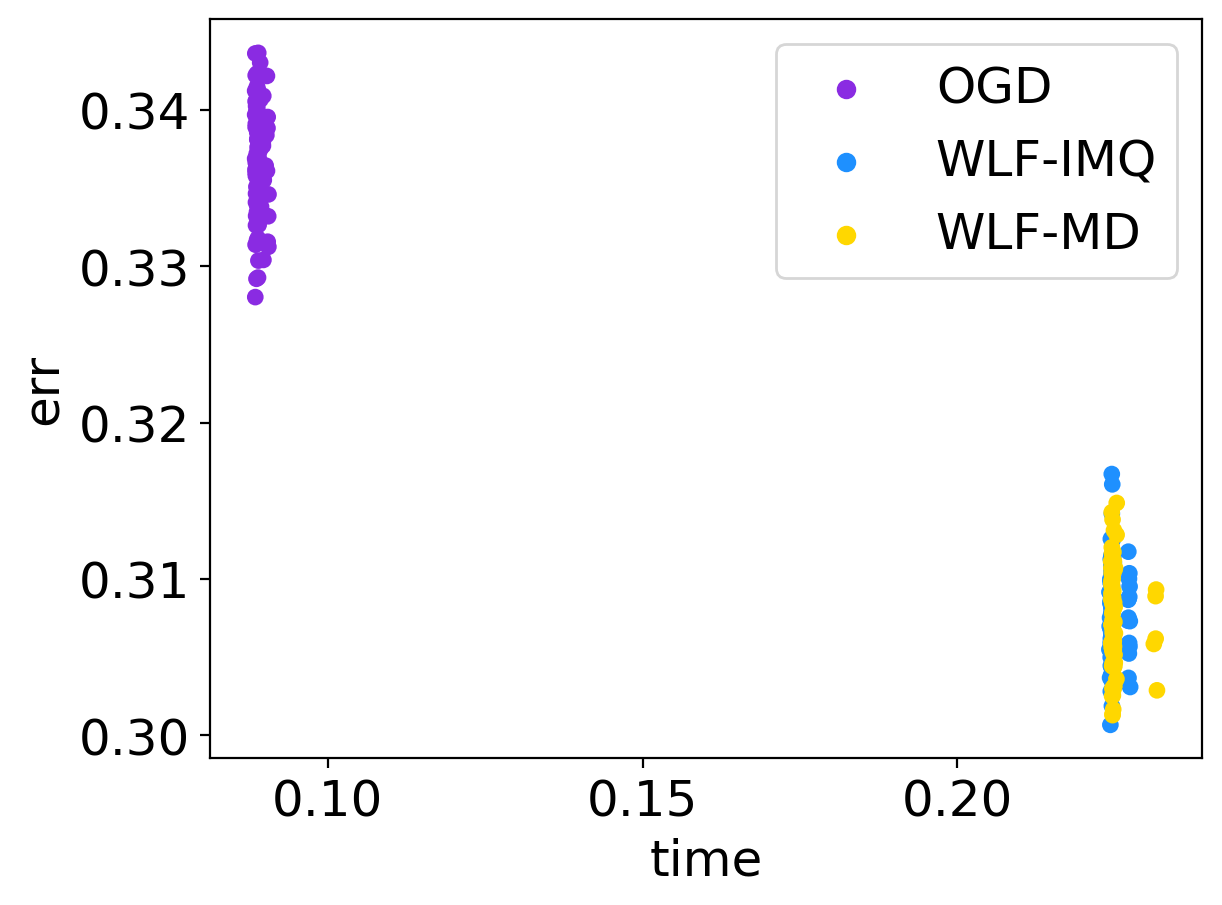

In [173]:
sns.scatterplot(
    x="time",
    y="err",
    hue="method",
    data=df.query("~method.str.startswith('KF')"),
    palette=cmap,
    linewidth=0.0,
)
# plt.yscale("log")
# plt.xscale("log")
plt.legend(bbox_to_anchor=(1,1))

## Store data

In [193]:
print(df.groupby("method").median().drop("run", axis=1))

              err      time
method                     
KF       0.625485  0.221366
KF-B     0.302951  2.582351
KF-IW    0.308743  1.590403
OGD      0.336644  0.088900
WLF-IMQ  0.307844  0.224502
WLF-MD   0.307080  0.224655


In [ ]:
df.groupby("method")["time"].mean()

method
KF         0.221824
KF-B       2.585608
KF-IW      1.584417
OGD        0.089483
WLF-IMQ    0.224893
WLF-MD     0.225067
Name: time, dtype: float64

In [194]:
data = {
    "datasets": {
        "X": np.array(X_collection),
        "y": np.array(y_collection),
    },
    "time": {k: np.array(v) for k, v in time_methods.items()},
    "posterior-states": hist_methods,
    "config": configs,
    "dataset-name": dataset_name,
    "p-error": p_error,
}

In [195]:
p_error_str = format(p_error * 100, "0.0f")
filename = f"{dataset_name}-{noise_type}-p-error{p_error_str}.pkl"
print(f"Storing in {filename}")
with open(filename, "wb") as f:
    pickle.dump(data, f)

Storing in naval-propulsion-plant-target-p-error10.pkl
